# IMPORTS

In [1]:
import os
import pathlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

# LOAD DATASET FOR 8 WORDS

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [3]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir / commands[0]))))

Number of total examples: 8000
Number of examples per label: 1000


# DATA PREPARATION FOR 8 WORDS

In [4]:
train_files = filenames[ : 6400]
val_files = filenames[6400 : 7200]
test_files = filenames[-800 : ]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))

Training set size: 6400
Validation set size: 800
Test set size: 800


# FUNCTIONS FOR DATA PREPROCESSING

In [5]:
def get_waveform_and_label(file_path):
    parts = tf.strings.split(
                                input = file_path,
                                sep = os.path.sep
                            )
    label = parts[-2]
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(contents = audio_binary)
    waveform = tf.squeeze(audio, axis = -1)
    return waveform, label

In [6]:
def get_spectrogram_and_label_id(audio, label):
    input_len = 16000
    waveform = audio[ : input_len]
    zero_padding = tf.zeros(
                                [16000] - tf.shape(waveform),
                                dtype = tf.float32
                           )
    waveform = tf.cast(waveform, dtype = tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
                                     equal_length,
                                     frame_length = 255,
                                     frame_step = 128
                                )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [7]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
                                map_func = get_waveform_and_label,
                                num_parallel_calls = tf.data.AUTOTUNE
                            )
    output_ds = output_ds.map(
                                map_func = get_spectrogram_and_label_id,
                                num_parallel_calls = tf.data.AUTOTUNE
                             )
    return output_ds

# DATA PREPROCESSING FOR 8 WORDS

In [8]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [9]:
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

test_audio = test_audio.reshape((800, 124, 129))

# LSTM FOR 8 WORDS

In [14]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(64, input_shape = (124, 129), return_sequences = True))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(64, return_sequences = True))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(64))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(64, activation = 'relu'))
LSTMmodel.add(Dropout(0.5))
LSTMmodel.add(Dense(8, activation = 'softmax'))

LSTMmodel.compile(
                    optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics = ['accuracy']
                 )

LSTMmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 124, 64)           49664     
                                                                 
 dropout_4 (Dropout)         (None, 124, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 124, 64)           33024     
                                                                 
 dropout_5 (Dropout)         (None, 124, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [15]:
history = LSTMmodel.fit(
                            train_ds,
                            validation_data = val_ds,
                            epochs = 50
                       )

Epoch 1/50
200/200 [==============================] - 40s 164ms/step - loss: 1.7869 - accuracy: 0.2828 - val_loss: 1.6106 - val_accuracy: 0.3675
Epoch 2/50
200/200 [==============================] - 31s 155ms/step - loss: 1.4471 - accuracy: 0.4480 - val_loss: 1.3008 - val_accuracy: 0.5150
Epoch 3/50
200/200 [==============================] - 31s 157ms/step - loss: 1.3304 - accuracy: 0.5167 - val_loss: 1.1769 - val_accuracy: 0.5825
Epoch 4/50
200/200 [==============================] - 31s 154ms/step - loss: 1.2295 - accuracy: 0.5683 - val_loss: 1.2334 - val_accuracy: 0.5612
Epoch 5/50
200/200 [==============================] - 32s 160ms/step - loss: 1.1773 - accuracy: 0.5992 - val_loss: 1.1031 - val_accuracy: 0.5962
Epoch 6/50
200/200 [==============================] - 30s 152ms/step - loss: 1.1142 - accuracy: 0.6247 - val_loss: 1.1338 - val_accuracy: 0.5950
Epoch 7/50
200/200 [==============================] - 30s 151ms/step - loss: 1.0294 - accuracy: 0.6322 - val_loss: 0.9215 - val_ac

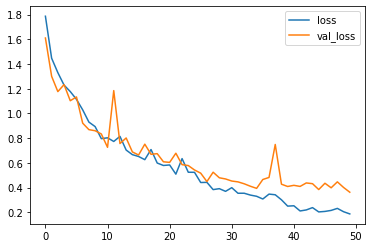

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# GRU FOR 8 WORDS

In [17]:
GRUmodel = Sequential()
GRUmodel.add(GRU(64, input_shape = (124, 129), return_sequences = True))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(GRU(64, return_sequences = True))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(GRU(64))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(Dense(64, activation = 'relu'))
GRUmodel.add(Dropout(0.5))
GRUmodel.add(Dense(8, activation = 'softmax'))

GRUmodel.compile(
                    optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics = ['accuracy']
                )

GRUmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 124, 64)           37440     
                                                                 
 dropout_8 (Dropout)         (None, 124, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 124, 64)           24960     
                                                                 
 dropout_9 (Dropout)         (None, 124, 64)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [18]:
history = GRUmodel.fit(
                            train_ds,
                            validation_data = val_ds,
                            epochs = 50
                      )

Epoch 1/50
200/200 [==============================] - 33s 133ms/step - loss: 2.0001 - accuracy: 0.1766 - val_loss: 1.8411 - val_accuracy: 0.2175
Epoch 2/50
200/200 [==============================] - 28s 138ms/step - loss: 1.7840 - accuracy: 0.2597 - val_loss: 1.7021 - val_accuracy: 0.3063
Epoch 3/50
200/200 [==============================] - 33s 164ms/step - loss: 1.5651 - accuracy: 0.3848 - val_loss: 1.3905 - val_accuracy: 0.4487
Epoch 4/50
200/200 [==============================] - 30s 152ms/step - loss: 1.1568 - accuracy: 0.5797 - val_loss: 1.0152 - val_accuracy: 0.6550
Epoch 5/50
200/200 [==============================] - 35s 177ms/step - loss: 0.9009 - accuracy: 0.6794 - val_loss: 0.7706 - val_accuracy: 0.7350
Epoch 6/50
200/200 [==============================] - 31s 157ms/step - loss: 0.7639 - accuracy: 0.7347 - val_loss: 0.6663 - val_accuracy: 0.7588
Epoch 7/50
200/200 [==============================] - 28s 142ms/step - loss: 0.5919 - accuracy: 0.8073 - val_loss: 0.5438 - val_ac

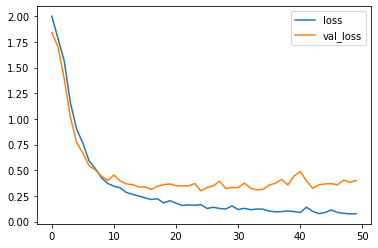

In [19]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# LSTM RESULTS FOR 8 WORDS

In [22]:
y_pred = np.argmax(LSTMmodel.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 2s 40ms/step
Test set accuracy: 90%


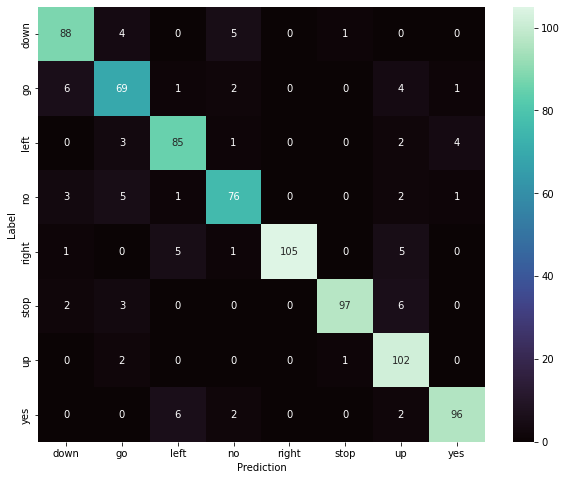

In [23]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(
                confusion_mtx,
                xticklabels = commands,
                yticklabels = commands,
                annot = True,
                fmt = 'g',
                cmap = 'mako'
           )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# GRU RESULTS FOR 8 WORDS

In [24]:
y_pred = np.argmax(GRUmodel.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 2s 27ms/step
Test set accuracy: 92%


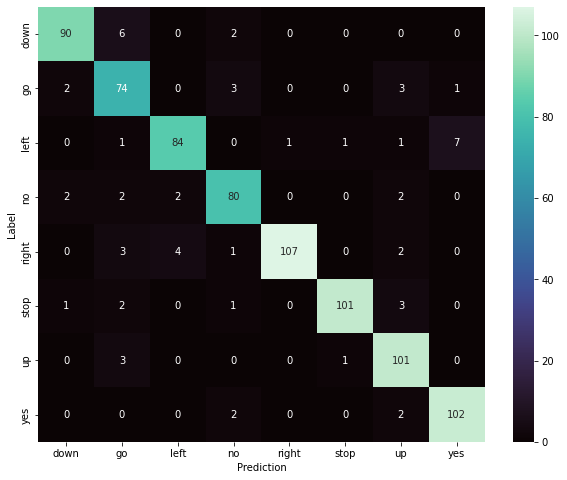

In [25]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(
                confusion_mtx,
                xticklabels = commands,
                yticklabels = commands,
                annot = True,
                fmt = 'g',
                cmap = 'mako'
           )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# LOAD DATASET FOR 30 WORDS

In [26]:
data_dir = pathlib.Path('data/speech_commands')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

print('Commands:', commands)

Commands: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [27]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir / commands[0]))))

Number of total examples: 51000
Number of examples per label: 1700


# DATA PREPARATION FOR 30 WORDS

In [28]:
train_files = filenames[ : 40800]
val_files = filenames[40800 : 45900]
test_files = filenames[-5100 : ]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))

Training set size: 40800
Validation set size: 5100
Test set size: 5100


# DATA PREPROCESSING FOR 30 WORDS

In [29]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [30]:
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

test_audio = test_audio.reshape((5100, 124, 129))

# LSTM FOR 30 WORDS

In [35]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(64, input_shape = (124, 129), return_sequences = True))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(64, return_sequences = True))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(64))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(64, activation = 'relu'))
LSTMmodel.add(Dropout(0.5))
LSTMmodel.add(Dense(30, activation = 'softmax'))

LSTMmodel.compile(
                    optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics = ['accuracy']
                 )

LSTMmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 124, 64)           49664     
                                                                 
 dropout_16 (Dropout)        (None, 124, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 124, 64)           33024     
                                                                 
 dropout_17 (Dropout)        (None, 124, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [36]:
history = LSTMmodel.fit(
                            train_ds,
                            validation_data = val_ds,
                            epochs = 50
                       )

Epoch 1/50
1275/1275 [==============================] - 224s 165ms/step - loss: 2.8842 - accuracy: 0.1359 - val_loss: 2.4432 - val_accuracy: 0.2371
Epoch 2/50
1275/1275 [==============================] - 207s 162ms/step - loss: 2.4102 - accuracy: 0.2563 - val_loss: 2.0878 - val_accuracy: 0.3429
Epoch 3/50
1275/1275 [==============================] - 207s 162ms/step - loss: 1.9685 - accuracy: 0.3964 - val_loss: 1.6384 - val_accuracy: 0.4976
Epoch 4/50
1275/1275 [==============================] - 200s 157ms/step - loss: 1.6728 - accuracy: 0.4961 - val_loss: 1.3524 - val_accuracy: 0.5906
Epoch 5/50
1275/1275 [==============================] - 194s 152ms/step - loss: 1.3678 - accuracy: 0.5950 - val_loss: 1.0704 - val_accuracy: 0.6867
Epoch 6/50
1275/1275 [==============================] - 208s 163ms/step - loss: 1.1374 - accuracy: 0.6793 - val_loss: 0.8725 - val_accuracy: 0.7510
Epoch 7/50
1275/1275 [==============================] - 196s 154ms/step - loss: 0.9598 - accuracy: 0.7356 - val_

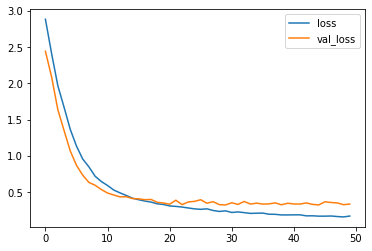

In [37]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# GRU FOR 30 WORDS

In [38]:
GRUmodel = Sequential()
GRUmodel.add(GRU(64, input_shape = (124, 129), return_sequences = True))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(GRU(64, return_sequences = True))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(GRU(64))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(Dense(64, activation = 'relu'))
GRUmodel.add(Dropout(0.5))
GRUmodel.add(Dense(30, activation = 'softmax'))

GRUmodel.compile(
                    optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics = ['accuracy']
                )

GRUmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 124, 64)           37440     
                                                                 
 dropout_20 (Dropout)        (None, 124, 64)           0         
                                                                 
 gru_4 (GRU)                 (None, 124, 64)           24960     
                                                                 
 dropout_21 (Dropout)        (None, 124, 64)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [39]:
history = GRUmodel.fit(
                            train_ds,
                            validation_data = val_ds,
                            epochs = 50
                      )

Epoch 1/50
1275/1275 [==============================] - 207s 151ms/step - loss: 2.9116 - accuracy: 0.1310 - val_loss: 1.9339 - val_accuracy: 0.3994
Epoch 2/50
1275/1275 [==============================] - 193s 152ms/step - loss: 1.4809 - accuracy: 0.5397 - val_loss: 0.8278 - val_accuracy: 0.7557
Epoch 3/50
1275/1275 [==============================] - 187s 146ms/step - loss: 0.9094 - accuracy: 0.7369 - val_loss: 0.5657 - val_accuracy: 0.8363
Epoch 4/50
1275/1275 [==============================] - 183s 144ms/step - loss: 0.6960 - accuracy: 0.8080 - val_loss: 0.5000 - val_accuracy: 0.8606
Epoch 5/50
1275/1275 [==============================] - 181s 142ms/step - loss: 0.6015 - accuracy: 0.8376 - val_loss: 0.4544 - val_accuracy: 0.8673
Epoch 6/50
1275/1275 [==============================] - 182s 142ms/step - loss: 0.5240 - accuracy: 0.8582 - val_loss: 0.4318 - val_accuracy: 0.8851
Epoch 7/50
1275/1275 [==============================] - 182s 143ms/step - loss: 0.4872 - accuracy: 0.8697 - val_

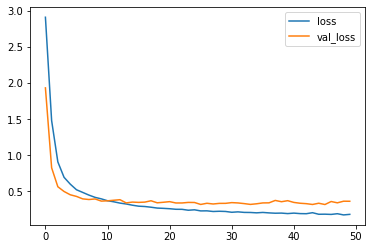

In [40]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# LSTM RESULTS FOR 30 WORDS

In [43]:
y_pred = np.argmax(LSTMmodel.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')

160/160 [==============================] - 13s 64ms/step
Test set accuracy: 93%


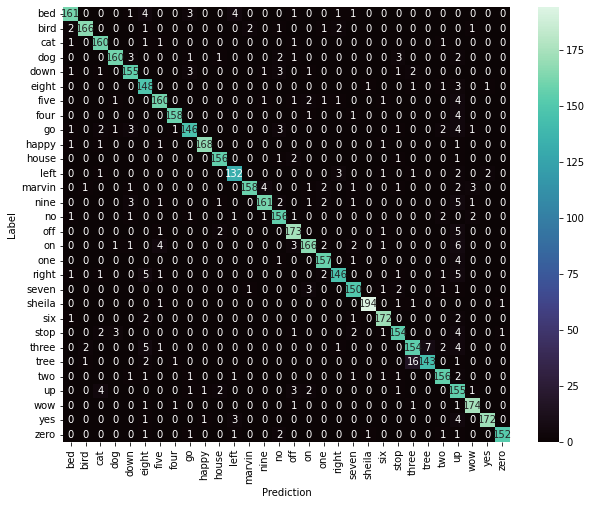

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(
                confusion_mtx,
                xticklabels = commands,
                yticklabels = commands,
                annot = True,
                fmt = 'g',
                cmap = 'mako'
           )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# GRU RESULTS FOR 30 WORDS

In [45]:
y_pred = np.argmax(GRUmodel.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')

160/160 [==============================] - 8s 40ms/step
Test set accuracy: 93%


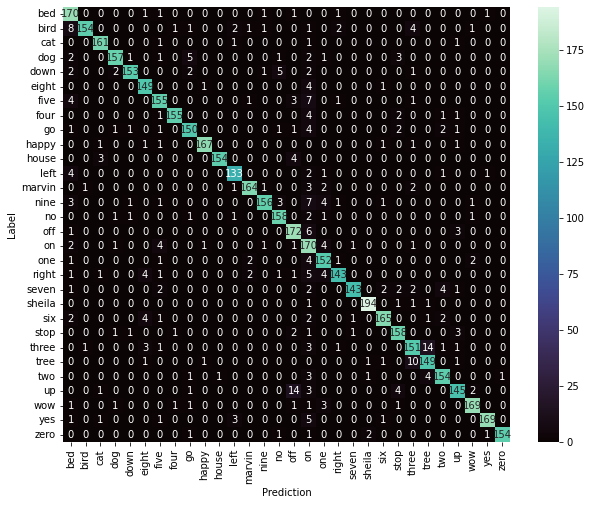

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(
                confusion_mtx,
                xticklabels = commands,
                yticklabels = commands,
                annot = True,
                fmt = 'g',
                cmap = 'mako'
           )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()